### 注册前向钩子（forward前），Module.register_forward_pre_hook(hook) -> torch.utils.hooks.RemovableHandle
* 返回类型是torch.utils.hooks.RemovableHandle，使用handle.remove()删掉该钩子
* 调用模块forward前执行钩子!!!
* 钩子函数格式是：hook(module, input) -> None or modified input，返回值为None或者返回修改后的input
* 钩子编程是编程范式

 -  假如你的模型有三个步骤才能走完。 你在第二个步骤后添加一个钩子。  模型运行时，会先运行前两个步骤，然后再执行钩子。再执行第三个步骤
      - 钩子可以把一些当前的数据带出来。实现可视化等功能。
      
 - return: 如果return了数据，return的数据将 改变input

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
'''主要改变输入的信息。
主要功能。在forward前修改输入
    - 本来输出是 1,2,1,1
    - 增加hook结果输出时 1,2,3,3
'''
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 2, 3)
        
    def forward(self, x):
        print("==[forward]==\t Do forward, x.shape is", x.shape)
        x = F.relu(self.conv1(x))
        output = F.relu(self.conv2(x))
        print("==[forward]==\t End forward, output shape is", output.shape)
        return output
    
def before_hook2(module, x):
    #input 是tuple
    print("==[Hook]==\t Pre Hook:", module, "\n==[Hook]==\t Input shape is:", x[0].shape)
    print(f"==[Hook]==\t ", module.conv1, sep="")
    return torch.zeros(1, 1, 7, 7) # 使得在forward前，输入数据已经从torch.zeros(1, 1, 5, 5)修改为torch.zeros(1, 1, 7, 7)

model2 = Model()
handle = model2.register_forward_pre_hook(before_hook2) # model2.后面注册，说明修改所有模型的前向。
input1 = torch.zeros(1, 1, 5, 5) # 输入形状(1, 1, 5, 5) ，正常经过网络卷积，输出应该是(1, 2, 1, 1)
model2(input1)
handle.remove()    # 删除

# 结论：register_forward_pre_hook钩子方便 模型的 修改输入数据。

==[Hook]==	 Pre Hook: Model(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
) 
==[Hook]==	 Input shape is: torch.Size([1, 1, 5, 5])
==[Hook]==	 Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
==[forward]==	 Do forward, x.shape is torch.Size([1, 1, 7, 7])
2
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139743865377872 	 output_id:139743865378112
3
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139743865378512 	 output_id:139743865378432
==[forward]==	 End forward, output shape is torch.Size([1, 2, 3, 3])


### 注册前向钩子（forward后），Module.register_forward_hook(hook) -> torch.utils.hooks.RemovableHandle
* 返回类型是torch.utils.hooks.RemovableHandle，使用handle.remove()删掉该钩子
* 调用模块forward后执行钩子
* 钩子函数格式是：hook(module, input, output) -> None or modified output，返回值为None或者返回修改后的output
* 钩子编程是编程范式

In [4]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 2, 3)
    def forward(self, x):
        print("==[forward]==\t Do forward, x.shape is", x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        print("==[forward]==\t End forward, output shape is", x.shape)
        return x

def hook_function(module, x, output):
    print(f"==[Hook]==\t this is register_forward_hook", module, f"\n==[Hook]==\t", "this is x\t", x[0].shape,f"\n==[Hook]==\t", "this is output\t", output.shape)
    # 本来，模型结果形状是  [1, 2, 1, 1]
    return torch.zeros(1, 1, 7, 7) # 但是hook在forward执行完。最后，return的结果改了output
    
model3 = Model3()
x = torch.randn((1, 1, 5, 5))
handel = model3.register_forward_hook(hook_function)
res = model3(x)
print(f"==[res]==\t", res.shape)
handel.remove()

# 结论：register_forward_hook钩子方便修改 模型的 输出数据。

==[forward]==	 Do forward, x.shape is torch.Size([1, 1, 5, 5])
4
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139750341919184 	 output_id:139743865338032
5
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139750341919984 	 output_id:139750341919904
==[forward]==	 End forward, output shape is torch.Size([1, 2, 1, 1])
==[Hook]==	 this is register_forward_hook Model3(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
) 
==[Hook]==	 this is x	 torch.Size([1, 1, 5, 5]) 
==[Hook]==	 this is output	 torch.Size([1, 2, 1, 1])
==[res]==	 torch.Size([1, 1, 7, 7])


#### 总结：
    - model.register_forward_pre_hook。  forward前的钩子return的值改的是input
    - model.register_forward_hook。      forward后的钩子return的值改的是output

### 直接替换forward函数
- 1. 时刻记得使用钩子函数的目的：使用onnx.helper。创建node、initilizer等，并得到输入, 输出，根据输入输出划线(形象的理解)

#### 1.0 nn层的forward替换

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 2, 3)
    def forward(self, x):
        print("==[forward]==\t Do forward, x.shape is", x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        print("==[forward]==\t End forward, output shape is", x.shape)
        return x

# 单独改torch.nn.Conv2d层的forward
def hook_function3(oldfunc):
    def inner_function(self, x): # 入参与原先的forward数量保持一致
        res = oldfunc(self, x)
        print(f"==[Hook]==\t type:{type(self)} \t input_id:{id(x)} \t output_id:{id(res)}")
        return res
    return inner_function


nn.Conv2d.forward = hook_function3(nn.Conv2d.forward) # 把nn.Conv2d.forward函数替换成了inner_function函数
# 一般一个函数结束，函数内部的变量、参数都会被释放掉。
# 而闭包特性不一样，根据闭包的特性，inner_function用到了hook_function3的入参--oldfunc，
    # 所以oldfunc并不会被释放，而是保存在__closure__中。
print(f"==[nn.Conv2d.forward.__closure__]==\t\t\t", nn.Conv2d.forward.__closure__) 
print(f"==[nn.Conv2d.forward.__closure__[0].cell_contents]==\t", nn.Conv2d.forward.__closure__[0].cell_contents) #闭包内的参数保存下来

# def printrelu(*args, **kwargs):
#     print("myrelu")
# nn.ReLU.forward = hook_function3(printrelu)  # F.relu 这种形式改不了

model4 = Model3().eval()
x = torch.randn((1, 1, 5, 5))
output = model4(x)
print(output.shape)
print(output)

# 总结：替换了 特定nn层 的forward函数。
# 方法：使用python特性，直接替换特定函数的实现，以实现自定义修改。
# 这种替换更为灵活。没有上面两个的局限性。 另外，这种写法，在没有影响结果的情况下，多做了一些事情

==[nn.Conv2d.forward.__closure__]==			 (<cell at 0x7f1a38038df0: function object at 0x7f18a7737a60>,)
==[nn.Conv2d.forward.__closure__[0].cell_contents]==	 <function hook_function3.<locals>.inner_function at 0x7f18a7737a60>
==[forward]==	 Do forward, x.shape is torch.Size([1, 1, 5, 5])
6
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139743865339792 	 output_id:139750341879904
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139743865339792 	 output_id:139750341879904
7
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139750341934272 	 output_id:139743865378032
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:139750341934272 	 output_id:139743865378032
==[forward]==	 End forward, output shape is torch.Size([1, 2, 1, 1])
torch.Size([1, 2, 1, 1])


## 1.1 在1.0的基础上，尝试添加创建onnx节点，了解会有哪些问题

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

# 新增的包
import onnx
import onnx.helper as helper
import numpy as np
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 2, 3)
    def forward(self, x):
        x = self.conv1(x) # F.relu的形式不行，这里为了演示，去掉F.relu
        x = self.conv2(x)
        return x

nodes = []
initializers = [] 
global_input_name = []
global_output_name = []
# global_input = [] # 暂时不需要保存global_input
# global_output = []

# 写inputs时需要
def append_initializer(value, name):
    initializers.append(#https://onnx.ai/onnx/api/helper.html#onnx.helper.make_tensor # 所有的数据value 添加到initializers列表中
        helper.make_tensor(
            name=name,
            data_type=helper.TensorProto.DataType.FLOAT, # 类型用FLOAT
            dims=list(value.shape),
            vals=value.cpu().data.numpy().astype(np.float32).tobytes(),
            raw=True
        )
    )
    return name    
  
def hook_function3(oldfunc, ilayer):
    def inner_function(self, x):
        # 新增层name计数
        nonlocal ilayer
        print(ilayer)
        ilayer += 1
        
        # 老函数的前向结果
        res = oldfunc(self, x) # 写inputs的时候，断点可以打在这里看conv.weight.data
        global_output_name.append(str(id(res)))
        # global_output.append(res)
        
        # 看内存地址打印信息
        print(f"==[Hook]==\t type:{type(self)} \t input_id:{id(x)} \t output_id:{id(res)}")    
        
        # inputs列表
        global_input_name.append(str(id(x)))
        # global_input.append(x)
        
        inputs = [
            str(id(x)), # 用x的id的字符串作为名字
            append_initializer(self.weight.data, f"conv{ilayer}.weight"), # scn中有permute这里weight的形状就是out in kernel kernel 所以不用permute
        ]
        if self.bias is not None: # 有 bias 的话，就会将 "spconv0.bias" 作为第三个元素
            inputs.append(append_initializer(self.bias.data, f"conv{ilayer}.bias"))

        # 添加onnx的node节点
        nodes.append(
            helper.make_node(
            name=f"Conv{ilayer}", # 使用ilayer区分名字
            op_type="Conv",
            inputs=inputs,
            outputs=[str(id(res))],  
            auto_pad="NOTSET",
            pads=[0, 0, 0, 0],
            group=1,
            dilations=[1, 1],
            kernel_shape=[3, 3],
            strides=[1, 1]
            )
        )
        
        return res
    return inner_function

ilayer = 0 # 新增变量，区分创建的onnx的名字
nn.Conv2d.forward = hook_function3(nn.Conv2d.forward, ilayer) # 把nn.Conv2d.forward函数替换成了inner_function函数


model4 = Model3().eval()
x = torch.randn((1, 1, 5, 5))
output = model4(x)
print(output)

inputs = [
    helper.make_value_info( #创建ValueInfoProto
        name=global_input_name[0],
        type_proto=helper.make_tensor_type_proto(
            elem_type=helper.TensorProto.DataType.FLOAT,
            shape=[1, 1, 5, 5]
        )
    )
]

outputs = [
    helper.make_value_info(
        name=global_output_name[-1],
        type_proto=helper.make_tensor_type_proto(
            elem_type=helper.TensorProto.DataType.FLOAT,
            shape=[1, 2, 1, 1]
        )
    )
]

graph = helper.make_graph(
    name="mymodel",
    inputs=inputs,
    outputs=outputs,
    nodes=nodes,
    initializer=initializers
)

# 如果名字不是ai.onnx，netron解析就不是太一样了
opset = [
    helper.make_operatorsetid("", 11)
]

# producer主要是保持和pytorch一致
model = helper.make_model(graph, opset_imports=opset, producer_name="pytorch", producer_version="1.9")

onnx.checker.check_model(model)
onnx.save_model(model, "trace.onnx")

print(model)
print("Done.!")

print(nodes)
print(global_input_name)
print(global_output_name)

# 总结：本案例主要确定创建onnx的思想。但是仍有问题。暂且不表
# 下面我们主要完善钩子函数，暂时不写onnx的逻辑


# 起始肉眼可见的缺点就有，名字太长。
    #　卷积这里只有两个，多增加卷积。就有可能涉及内存的问题


0
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:140192944507696 	 output_id:140192944508176
1
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:140192944508176 	 output_id:140192944508576
tensor([[[[ 0.4775]],

         [[-0.1290]]]], grad_fn=<ThnnConv2DBackward0>)
ir_version: 9
opset_import {
  domain: ""
  version: 11
}
producer_name: "pytorch"
producer_version: "1.9"
graph {
  node {
    input: "140192944507696"
    input: "conv1.weight"
    input: "conv1.bias"
    output: "140192944508176"
    name: "Conv1"
    op_type: "Conv"
    attribute {
      name: "auto_pad"
      type: STRING
      s: "NOTSET"
    }
    attribute {
      name: "dilations"
      type: INTS
      ints: 1
      ints: 1
    }
    attribute {
      name: "group"
      type: INT
      i: 1
    }
    attribute {
      name: "kernel_shape"
      type: INTS
      ints: 3
      ints: 3
    }
    attribute {
      name: "pads"
      type: INTS
      ints: 0
      ints: 0
      int

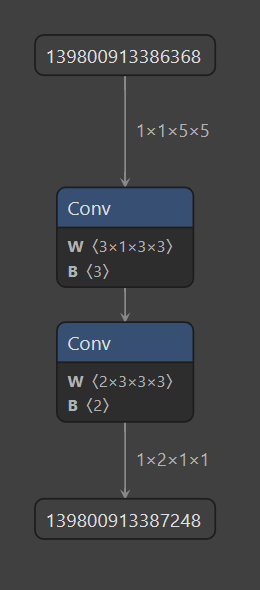

In [2]:
# 模型推理
import onnxruntime
import numpy as np
import torch

# 准备输入数据
x = x.numpy()
input_val = np.array(x, dtype=np.float32)

# 加载模型并指定执行提供者
sess = onnxruntime.InferenceSession("trace.onnx", providers=['CPUExecutionProvider'])

# 获取模型的输入名称
input_name = sess.get_inputs()[0].name

# 运行模型
output = sess.run(None, {input_name: input_val})

print(output[0].shape)
print(output[0])


(1, 2, 1, 1)
[[[[ 0.47749427]]

  [[-0.12904355]]]]


#### 2.0 relu也替换掉的例子
- 这里换了一个conv与relu分开的网络
- 引出内存id的复用问题。

In [ ]:
import numpy as np
import torch.nn as nn
import torch

class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 1, 1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 1, 1, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x
        
# 1.0演示直接替换    
# def printconv(*args, **kwargs):
#     print("myconv")
# def printrelu(*args, **kwargs):
#     print("myrelu")
    
# nn.Conv2d.forward = printconv   
# nn.ReLU.forward = printrelu  
  
# 2.0 正式代码
def hook_function(oldfunc): # 传入的参数是一个函数地址，即被替换掉的函数。
    def inner_function(self, x): # 内部的函数参数形式要与forward一样。
        res = oldfunc(self, x)
        print(f"==[Hook]==\t {type(self)}, input id = {id(x)}, output id = {id(res)}")
        return res
    return inner_function
    
nn.Conv2d.forward = hook_function(nn.Conv2d.forward) # 替换所有Conv2d模块的前向函数
nn.ReLU.forward =   hook_function(nn.ReLU.forward)   

model = Model5().eval()
input = torch.zeros(1, 3, 3, 3)
a = model(input)        

myconv
myrelu
myconv


In [ ]:
'''
==[Hook]==	 <class 'torch.nn.modules.conv.Conv2d'>, input id = 139901407312928, output id = 139901407312448
==[Hook]==	 <class 'torch.nn.modules.activation.ReLU'>, input id = 139901407312448, output id = 139901407310768
==[Hook]==	 <class 'torch.nn.modules.conv.Conv2d'>, input id = 139901407310768, output id = 139901407312448

id = 139901407312448 出现了多次。这是因为pytorch的内存复用造成的结果。
'''

#### 3.0 更新版
- 对程序进一步修改。
- 主要功能仍然是，将nn模块自带的forward函数，在功能(前向)不变的情况下，替换为自定义myforward函数。
- 使用带参装饰器，参数为想要改变的 nn模块 + forwar字符串。
  - 例如像改变  Conv2d 模块 的 forward。 传参 "torch.nn.Conv2d.forward"
- 使用getattr，在函数内得到与装饰器参数一致的forward对象
- 使用setattr，真正做到修改forward函数
- 使用clone()，解决pytorch自动优化tensor导致tensor复用的问题。仍然留下一个问题

In [ ]:
# 为什么要避免复用？
# 主要和后面构建onnx有关。
# ==[Hook]==	 <class 'torch.nn.modules.conv.Conv2d'>, input id = 139901407312928, output id = 139901407312448
# ==[Hook]==	 <class 'torch.nn.modules.activation.ReLU'>, input id = 139901407312448, output id = 139901407310768
# ==[Hook]==	 <class 'torch.nn.modules.conv.Conv2d'>, input id = 139901407310768, output id = 139901407312448
# 从打印结果看，第一个Conv2d的output的id与第二个Conv2d的output的id一致。这样在构建graph时会出现问题。

In [ ]:
import numpy as np
import torch.nn as nn
import torch

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 1, 1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 1, 1, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x
        
def hook_forward(fn):# 再包裹一层，使得能够使用装饰器。
    fnname_list = fn.split(".") # ['torch', 'nn', 'Conv2d', 'forward']
    layer_name = eval(".".join(fnname_list[:-1])) # 得到torch.nn.Conv2d
    fn_name = fnname_list[-1] # "forward"
    oldfn = getattr(layer_name, fn_name) # 得到<function Conv2d.forward at 0x000002AAED0B8940>
                                         # <function ReLU.forward at 0x000002AAED0D31F0>
    
    def make_hook(bind_func):
        
        def myforward(self, x):
            y = oldfn(self, x).clone() # 避免pytorch对tensor复用，但并不能总是保证id唯一。为何要避免复用，见最后面？
            bind_func(self, x, y) 
            return y
        
        setattr(layer_name, fn_name, myforward) # 改变forward
        
        return myforward
    
    return make_hook
    

@hook_forward("torch.nn.Conv2d.forward")
def symbolic_conv2d(self, x, y):
    print(f"{type(self)}, input id = {id(x)}, output id = {id(y)}")
    
@hook_forward("torch.nn.ReLU.forward")
def symbolic_relu(self, x, y):
    print(f"{type(self)}, input id = {id(x)}, output id = {id(y)}")
    
model = Model().eval()
input1 = torch.ones(1, 3, 3, 3)
a = model(input1)
a


# layer_name有哪些键
# for k,v in vars(layer_name).items():
#     print(k)
# __module__
# __doc__
# __init__
# _conv_forward
# forward

# id有什么变化
# 除特殊情况，id已经没有重复的了。



<class 'torch.nn.modules.conv.Conv2d'>, input id = 139735143086256, output id = 139735143200224
<class 'torch.nn.modules.activation.ReLU'>, input id = 139735143200224, output id = 139735143200704
<class 'torch.nn.modules.conv.Conv2d'>, input id = 139735143200704, output id = 139735143200464


tensor([[[[-0.1670, -0.1670, -0.1670],
          [-0.1670, -0.1670, -0.1670],
          [-0.1670, -0.1670, -0.1670]]]], grad_fn=<CloneBackward0>)

"""
执行顺序说明：
1.0 代码从上往下执行, 先导入各种模块, 定义Model类，定义hook_forward函数

2.0 再执行到带参数的@hook_forward装饰器。执行hook_forward前4行代码
    定义make_hook函数，返回make_hook的引用

3.0 定义symbolic_conv2d函数，当被装饰的函数symbolic_conv2d定义好了
    则将被装饰的函数作为参传入刚刚执行装饰器返回的myforward函数并执行, 
    即执行myforward(symbolic_conv2d)
    
4.0 再定义myforward函数, 利用setattr，用myforward替换掉
    <class 'torch.nn.modules.conv.Conv2d'>的forward属性，

ReLU的执行重复3.0  4.0 即
5.0 再执行到带参数的@hook_forward装饰器。执行hook_forward前4行代码
    定义make_hook函数，返回make_hook的引用

6.0 再定义myforward函数, 利用setattr，用myforward替换掉
    <class 'torch.nn.modules.activation.ReLU'>的forward属性

7.0 实例化Model，执行__init__，置为eval模式，构造数据，执行model的前向forward

8.0 在执行self.conv1(x)时，实际执行的是hook_forward中的make_hook中的myforward
    

## 4.0 再改进版
- tensor什么时候会复用？
    - 答案：在tensor没有任何引用的时候，tensor会被回收，并且会被复用
    - 举例：在forward函数中
    
    ![Alt text](./image.png)
    
        - 执行完self.conv1(x)后，x1的引用计数减1，此时引用计数不一定为0(外面可能会有别的引用)，x1不一定会被回收
        - 执行完self.relu(x)后, x2是真正的没有引用了。此时就可能被复用
        - 在执行self.conv2(x)时。等号左边的x6需要新的内存，
            - 此时发现x2没有引用了，内存还没被释放
            - 于是就会使用这个内存。

- 如何不让他复用？
    - 解决方案是，使其引用计数一直存在，不释放。
    



- 目标1：彻底解决tensor复用问题
- 方法：创建全局变量  列表 all_tensors, 将新myforward函数的产生的所有输入输出，都存起来。始终不让tensor引用计数器变为0
- 新增功能：把print打印的地址id，转换成从1开始的数字。主要是为了方便观看。

In [3]:
import numpy as np
import torch.nn as nn
import torch

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 1, 1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 1, 1, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x
        
def hook_forward(fn):
    nnmodule_list = fn.split(".")
    nnmodule_name = eval(".".join(nnmodule_list[:-1])) 
    func_name = nnmodule_list[-1]
    oldfunc = getattr(nnmodule_name, func_name)
    
    def make_hook(bind_func):
        def newforward(self, x):
            global all_tensors
            y = oldfunc(self, x)
            all_tensors.extend([x, y])
            bind_func(self, x, y)
            return y
        setattr(nnmodule_name, func_name, newforward)
    return make_hook

def get_obj_id(obj):
    global objmap # 引入global变量objmap
    obj_id = id(obj) # 用id作为键，用长度作为值。
    
    if obj_id not in objmap:
        objmap[obj_id] = len(objmap)
    return objmap[obj_id]
        
    
@hook_forward("torch.nn.Conv2d.forward")
def symbolic_conv2d(self, x, y):
    print(f"{type(self)}, input id = {get_obj_id(x)}, output id = {get_obj_id(y)}")
    
@hook_forward("torch.nn.ReLU.forward")
def symbolic_relu(self, x, y):
    print(f"{type(self)}, input id = {get_obj_id(x)}, output id = {get_obj_id(y)}")
    
all_tensors = []
objmap = {} 
    
model = Model().eval()
input1 = torch.ones(1, 3, 3, 3)
a = model(input1)
a


'''
<class 'torch.nn.modules.conv.Conv2d'>, input id = 0, output id = 1
<class 'torch.nn.modules.activation.ReLU'>, input id = 1, output id = 2
<class 'torch.nn.modules.conv.Conv2d'>, input id = 2, output id = 3
[3]:
tensor([[[[-1.1552, -1.1552, -1.1552],
          [-1.1552, -1.1552, -1.1552],
          [-1.1552, -1.1552, -1.1552]]]], grad_fn=<ConvolutionBackward0>)
'''

2
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:140192944592352 	 output_id:140192369543104
<class 'torch.nn.modules.conv.Conv2d'>, input id = 0, output id = 1
<class 'torch.nn.modules.activation.ReLU'>, input id = 1, output id = 2
3
==[Hook]==	 type:<class 'torch.nn.modules.conv.Conv2d'> 	 input_id:140192369543504 	 output_id:140192369543424
<class 'torch.nn.modules.conv.Conv2d'>, input id = 2, output id = 3


"\n<class 'torch.nn.modules.conv.Conv2d'>, input id = 0, output id = 1\n<class 'torch.nn.modules.activation.ReLU'>, input id = 1, output id = 2\n<class 'torch.nn.modules.conv.Conv2d'>, input id = 2, output id = 3\n[3]:\ntensor([[[[-1.1552, -1.1552, -1.1552],\n          [-1.1552, -1.1552, -1.1552],\n          [-1.1552, -1.1552, -1.1552]]]], grad_fn=<ConvolutionBackward0>)\n"

导出onnx

In [ ]:
import torch
import torch.nn as nn
import onnx
import onnx.helper as helper
import numpy as np

# reference
# https://github.com/shouxieai/learning-cuda-trt/blob/main/tensorrt-basic-1.4-onnx-editor/create-onnx.py

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 1, 1, 1) 
        self.conv_right = nn.Conv2d(3, 3, 1, 1) 
    
    def forward(self, x):
        r = self.conv_right(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x + r) # 与上一个案例不同。这里增加了一个分支。目的是让onnx看起来复杂一点。不重要
        return x

def hook_forward(fn):
    # torch.Tensor.__add__
    fnnames   = fn.split(".")
    fn_module = eval(".".join(fnnames[:-1])) # torch.Tensor
    fn_name   = fnnames[-1] # __add__
    oldfn = getattr(fn_module, fn_name) # getattr(torch.Tensor,  "__add__")
    
    def make_hook(bind_fn):

        ilayer = 0  # 与上一个案例不同 ， 新增统计层数的变量
        def myforward(self, x):
            global all_tensors
            nonlocal ilayer
            y = oldfn(self, x)

            bind_fn(self, ilayer, x, y)
            all_tensors.extend([x, y])   # 避免torch对tensor进行复用
            ilayer += 1
            return y

        setattr(fn_module, fn_name, myforward)
    return make_hook

@hook_forward("torch.nn.Conv2d.forward")
def symbolic_conv2d(self, ilayer, x, y):
    # get_obj_idd方法，用字典的长度代表序号。序号用于追踪每个tensor
    print(f"{type(self)} -> Input {get_obj_idd(x)}, Output {get_obj_idd(y)}")
    
    inputs = [ 
        get_obj_idd(x), # 层的输入x 对应的编号
        append_initializer(self.weight.data, f"conv{ilayer}.weight"), 
        append_initializer(self.bias.data, f"conv{ilayer}.bias")
    ]

    nodes.append(
        helper.make_node( # 真正创建onnx节点
            "Conv", inputs, [get_obj_idd(y)], f"conv{ilayer}",   
            kernel_shape=self.kernel_size, group=self.groups, pads=[0, 0] + list(self.padding), dilations=self.dilation, strides=self.stride
            # op_type = "Conv"  ， inputs = inputs ， outputs = [get_obj_idd(y)]， name = f"conv{ilayer}"
            # pads=[0, 0] + list(self.padding) 是因为这里的pads 需要格式是列表中中4个数   [0, 0， 0， 0]
        )

    )


@hook_forward("torch.nn.ReLU.forward") # 将torch.nn.ReLU.forward 方法，替换为  myforward
def symbolic_relu(self, ilayer, x, y):
    print(f"{type(self)} -> Input {get_obj_idd(x)}, Output {get_obj_idd(y)}")

    nodes.append(
        helper.make_node(
            "Relu", [get_obj_idd(x)], [get_obj_idd(y)], f"relu{ilayer}"
        )
    )

@hook_forward("torch.Tensor.__add__")
def symbolic_add(a, ilayer, b, y): 
    # 新增一个add，因为网络中涉及x = self.conv2(x + r)， 存在 x + r。 
     # + 加号  在 torch.Tensor中，对python的魔术方法 __add__重写了。
     # 所以，我们也需要把 torch.Tensor.__add__ 方法   替换为  我们自己的  add方法。
     # 将torch.Tensor.__add__ 方法，替换为  myforward
    print(f"Add -> Input {get_obj_idd(a)} + {get_obj_idd(b)}, Output {get_obj_idd(y)}")

    nodes.append(
        helper.make_node(
            "Add", [get_obj_idd(a), get_obj_idd(b)], [get_obj_idd(y)], f"add{ilayer}"
        )
    )

def append_initializer(value, name): # weight、bais在onnx中储存在initializer层。
    initializers.append(
        helper.make_tensor(
            name=name, # 以卷积为例一般为："conv.weight"或"conv.bias"
            data_type=helper.TensorProto.DataType.FLOAT,
            dims=list(value.shape),
            vals=value.data.numpy().astype(np.float32).tobytes(),
            raw=True
        )
    )
    return name


def get_obj_idd(obj):
    global objmap

    idd = id(obj)
    if idd not in objmap:
        objmap[idd] = str(len(objmap))
    return objmap[idd]

all_tensors = []
objmap = {}
nodes = []
initializers = []

torch.manual_seed(31)
x = torch.full((1, 3, 3, 3), 0.55)
model = Model().eval()
y = model(x)

inputs = [
    helper.make_value_info(
        name="0",
        type_proto=helper.make_tensor_type_proto(
            elem_type=helper.TensorProto.DataType.FLOAT,
            shape=["batch", x.size(1), x.size(2), x.size(3)] 
            # batch用字符串，或-1，表示动态
        )
    )
]

outputs = [
    helper.make_value_info(
        name="5",
        type_proto=helper.make_tensor_type_proto(
            elem_type=helper.TensorProto.DataType.FLOAT,
            shape=["batch", y.size(1), y.size(2), y.size(3)]
        )
    )
]

graph = helper.make_graph(
    name="mymodel",
    inputs=inputs,
    outputs=outputs,
    nodes=nodes,
    initializer=initializers
)

# 如果名字不是ai.onnx，netron解析就不是太一样了
opset = [
    helper.make_operatorsetid("ai.onnx", 11)
]

# !!!!!!!!!producer主要是保持和pytorch一致
model = helper.make_model(graph, opset_imports=opset, producer_name="pytorch", producer_version="1.9")
onnx.save_model(model, "custom.onnx")

print(y)